In [1]:
import sys
sys.path.append("../")
from inference.dan import DANv5

dan = DANv5(model_path="../weights/dan_b2_fp16.engine")

⚙️ Loading TensorRT inference engine ../weights/dan_b2_fp16.engine
⚙️ TensorRT engine loaded successfully.
 - 📥 Input images_a: shape (2, 3, 1280, 1280), dtype float16
 - 📥 Input images_b: shape (2, 3, 640, 640), dtype float16
 - 📤 Output output_a0: shape (2, 102000, 14), dtype float16
 - 📤 Output output_a1: shape (2, 500), dtype float16
 - 📤 Output output_a2: shape (2, 500), dtype float16
 - 📤 Output output_b0: shape (2, 25200, 14), dtype float16
 - 📤 Output output_b1: shape (2, 500), dtype float16
 - 📤 Output output_b2: shape (2, 500), dtype float16
⏳ Warming up...


In [2]:
from urllib.request import urlopen
import numpy as np
from PIL import Image
from utils.horizon import draw_horizon, draw_bboxes

url_rgb = "https://github.com/SEA-AI/.github/blob/main/assets/example_1_RGB.jpg?raw=true"
url_ir = "https://github.com/SEA-AI/.github/blob/main/assets/example_1_IR.jpg?raw=true"

image_rgb = np.array(Image.open(urlopen(url_rgb)).convert("RGB"))
image_ir = np.array(Image.open(urlopen(url_ir)).convert("RGB"))

image_rgb = np.stack([image_rgb for _ in range(dan.model.input_bs[0])], axis=0)
image_ir = np.stack([image_ir for _ in range(dan.model.input_bs[1])], axis=0)

dan((image_rgb, image_ir))
n = 100
for i in range(n):
    preds_rgb, preds_ir = dan((image_rgb, image_ir))

# print average times
for name, profile in dan.profiles.items():
    print(f"{profile.t / n * 1E3:>5.1f} ms [avg] - {name}")

preds = preds_rgb[0]
image = image_rgb[0]


def draw_preds(image, preds):
    I = image.copy()
    bboxes = preds[:, :4]  # x1, y1, x2, y2
    scores = preds[:, 4]  # scores (probabilities)
    classes = preds[:, 5]  # indices of classes

    hor_points, hor_score = bboxes[classes == -1], scores[classes == -1]
    bboxes, scores, classes = (
        bboxes[classes != -1],
        scores[classes != -1],
        classes[classes != -1],
    )

    dets = np.hstack((bboxes, scores[:, np.newaxis], classes[:, np.newaxis]))
    I = draw_bboxes(I, dets, color=(0, 0, 255), thickness=1)
    I = draw_horizon(
        I, keypoints=hor_points.reshape(-1, 2), color=(0, 255, 0), diameter=1
    )
    return Image.fromarray(I)

 29.9 ms [avg] - preprocess
 18.6 ms [avg] - inference
  7.8 ms [avg] - postprocess


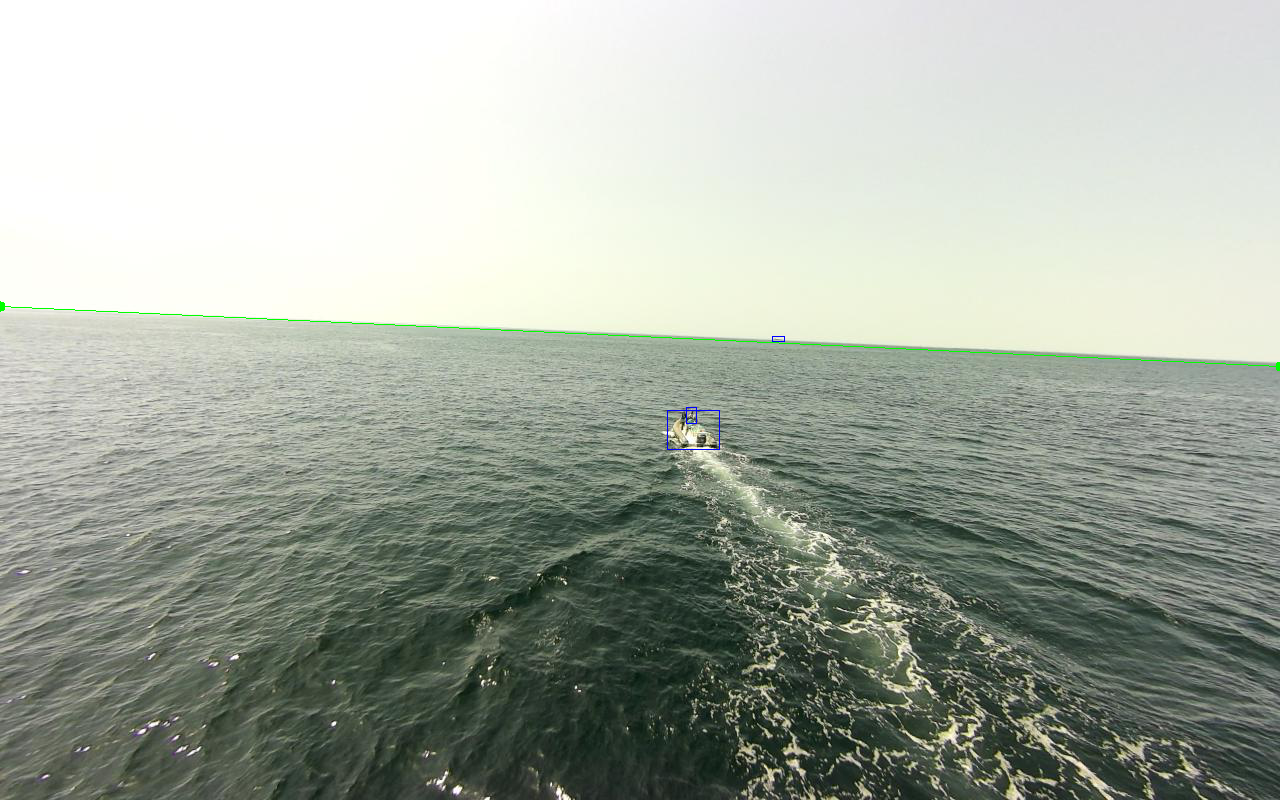

In [3]:
draw_preds(image_rgb[0], preds_rgb[0])

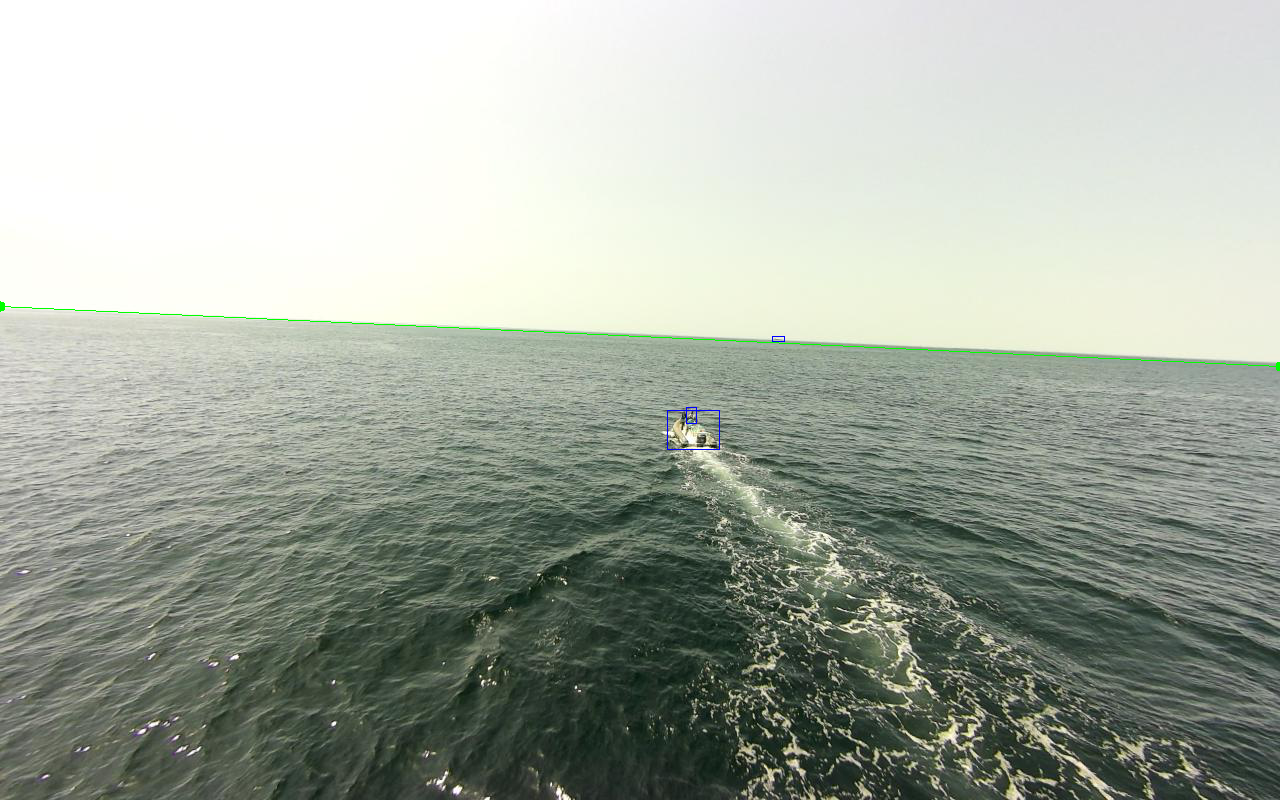

In [4]:
draw_preds(image_ir[0], preds_ir[0])

In [5]:
# inference
dan.detect((image_rgb, image_ir), output_mode="tf")

[[{'detection_boxes': array([[0.420625  , 0.60351562, 0.426875  , 0.61289063],
          [0.50875   , 0.5359375 , 0.52875   , 0.54375   ],
          [0.5125    , 0.52109375, 0.56125   , 0.56171875],
          [0.38707717, 0.        , 0.45749426, 1.        ]]),
   'detection_scores': array([0.62988281, 0.23095703, 0.81152344, 0.27294922]),
   'detection_classes': array([ 2.,  1.,  4., -1.]),
   'num_detections': 4},
  {'detection_boxes': array([[0.420625  , 0.60351562, 0.426875  , 0.61289063],
          [0.50875   , 0.5359375 , 0.52875   , 0.54375   ],
          [0.5125    , 0.52109375, 0.56125   , 0.56171875],
          [0.38707717, 0.        , 0.45749426, 1.        ]]),
   'detection_scores': array([0.62988281, 0.23095703, 0.81152344, 0.27294922]),
   'detection_classes': array([ 2.,  1.,  4., -1.]),
   'num_detections': 4}],
 [{'detection_boxes': array([[0.25742188, 0.48388672, 0.2640625 , 0.49755859],
          [0.26953125, 0.95214844, 0.278125  , 0.96386719],
          [0.24023438,

In [6]:
batch_outputs = dan.detect((image_rgb, image_ir), output_mode="qa")
for n, batch_preds in enumerate(batch_outputs):
    print(f"-- Output {n}")
    for i, sample_preds in enumerate(batch_preds):
        print(f"Sample {i}:")
        for bbox, label, cls, score in sample_preds:
            print(f"{bbox=}, {label=}, {cls=}, {score=}")

-- Output 0
Sample 0:
bbox=array([0.60351562, 0.420625  , 0.61289063, 0.426875  ]), label='BOAT', cls=1, score=0.6298828125
bbox=array([0.5359375, 0.50875  , 0.54375  , 0.52875  ]), label='HUMAN', cls=7, score=0.23095703125
bbox=array([0.52109375, 0.5125    , 0.56171875, 0.56125   ]), label='MOTORBOAT', cls=9, score=0.8115234375
bbox=array([0.        , 0.38707717, 1.        , 0.45749426]), label='HORIZON', cls=6, score=0.27294921875
Sample 1:
bbox=array([0.60351562, 0.420625  , 0.61289063, 0.426875  ]), label='BOAT', cls=1, score=0.6298828125
bbox=array([0.5359375, 0.50875  , 0.54375  , 0.52875  ]), label='HUMAN', cls=7, score=0.23095703125
bbox=array([0.52109375, 0.5125    , 0.56171875, 0.56125   ]), label='MOTORBOAT', cls=9, score=0.8115234375
bbox=array([0.        , 0.38707717, 1.        , 0.45749426]), label='HORIZON', cls=6, score=0.27294921875
-- Output 1
Sample 0:
bbox=array([0.48388672, 0.25742188, 0.49755859, 0.2640625 ]), label='FAR_AWAY_OBJECT', cls=4, score=0.56396484375
bb